<a href="https://colab.research.google.com/github/ryanharvey1/dissertation_analyses/blob/master/RippleNet_interactive_prototype.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# RippleNet_interactive_prototype
Test implementation of user-interactive detection and rejection of detected SPW-R events using RippleNet.

Author: Espen Hagen (<https://github.com/espenhgn>)

LICENSE: <https://github.com/CINPLA/RippleNet/blob/master/LICENSE>

In [ ]:
# allow running on Google Colab for training, validation etc. 
try:
    from google.colab import drive
    drive.mount('/content/drive')
    %cd /content/drive/My Drive/Colab Notebooks/RippleNet
    %tensorflow_version 2.x
except:
    pass


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive
/content/drive/My Drive/Colab Notebooks/RippleNet


In [ ]:
!pip install -r requirements.txt

     |████████████████████████████████| 471kB 2.8MB/s 


In [ ]:
!pip install ripple_detection
from ripple_detection.core import (exclude_close_events, exclude_movement, filter_ripple_band,
                   gaussian_smooth, get_envelope,
                   merge_overlapping_ranges, threshold_by_zscore)

In [ ]:
# %matplotlib widget
# %matplotlib inline

In [ ]:
import os
import numpy as np
import scipy.signal as ss
from matplotlib import pyplot as plt
from matplotlib.widgets import Button
import tensorflow
import tensorflow as tf
from tensorflow import keras
import h5py
from matplotlib import colors
from time import time, sleep
import pickle
import pandas as pd
import glob

In [ ]:
from tensorflow.python.client import device_lib
print('running Tensorflow v{}'.format(tf.__version__))
print('running on devices:\n', device_lib.list_local_devices())
print('Num GPUs Available: ', len(tf.config.experimental.list_physical_devices('GPU')))
print('GPU device:\n', tf.test.gpu_device_name())

running Tensorflow v2.3.0
running on devices:
 [name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 2899322902909652613
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 11035908039522010607
physical_device_desc: "device: XLA_CPU device"
]
Num GPUs Available:  0
GPU device:
 


In [ ]:
# fix seeds for reproducible results
np.random.seed(1234)
tf.random.set_seed(12345)

# Load RippleNet instance

In [ ]:
# load info on best model (path, threhsold settings)
# with open('best_model.pkl', 'rb') as f:
#     best_model = pickle.load(f)
#     print(best_model)
# best_model = {'model_file': '/content/gdrive/My Drive/Colab Notebooks/RippleNet/trained_networks/ripplenet_bidirectional_best_random_seed123.h5',
#               'threshold': 0.7, 'width': 0.0, 'distance': 62}    

best_model = {'model_file': 'trained_networks/ripplenet_bidirectional_random_seed123.h5', 'threshold': 0.7, 'width': 0.0, 'distance': 62}

In [ ]:
model = keras.models.load_model("my_model")
model.summary()

Model: "RippleNet"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, 1)]         0         
_________________________________________________________________
gaussian_noise (GaussianNois (None, None, 1)           0         
_________________________________________________________________
conv1d (Conv1D)              (None, None, 20)          220       
_________________________________________________________________
batch_normalization (BatchNo (None, None, 20)          80        
_________________________________________________________________
dropout (Dropout)            (None, None, 20)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 10)          2210      
_________________________________________________________________
batch_normalization_1 (Batch (None, None, 10)          40

In [ ]:
# load the 'best' performing model on the validation sets
# model = keras.models.load_model(best_model['model_file'])
# model = keras.models.load_model('/content/gdrive/My Drive/Colab Notebooks/RippleNet/trained_networks/ripplenet_bidirectional_best_random_seed123.h5')

# model.summary()

# Parameters

In [ ]:
# some needed parameters
Fs = 1250 # Hz, sampling freq
lag = int(100 * Fs / 1000) # 100 ms @ Fs

# Threshold settings for detecting ripple events from prediction, 
threshold = best_model['threshold'] # detection threshold on the interval (0, 1)
distance = best_model['distance']  # timesteps, distance*Fs/1000 peak interdistance in units of ms
width = best_model['width']       # timesteps, width*Fs/1000 peak width in units of ms. 
# see scipy.signal.find_peaks documentation

In [ ]:
# bandpass-filter LFP filter settings
Wn = (150 / (Fs / 2), 250 / (Fs / 2)) # critical frequencies
N = 2                                 # filter order
b, a = ss.butter(N, Wn, btype='bandpass') # filter coefficients 

In [ ]:
# Wavelet parameters for spectrograms
S_freqs = np.arange(100., 251, 10) # Hz, wavelet spectrogram frequencies

#set up continuous wavelets
w=6.
s=1.

#wavelets
waveletfun = ss.morlet
wavelets = []
for i, freq in enumerate(S_freqs):
    kwargs = {
        'M' : int(2. * s * Fs * w / freq),
        'w' : w,
        's' : s,
        'complete' : True,
    }
    wl = waveletfun(**kwargs)
    wavelets.append(wl)

# Session time series

In [ ]:
import sys,os

def loadXML(path):
    """
    path should be the folder session containing the XML file
    Function returns :
        1. the number of channels
        2. the sampling frequency of the dat file or the eeg file depending of what is present in the folder
            eeg file first if both are present or both are absent
        3. the mappings shanks to channels as a dict
    Args:
        path : string
    Returns:
        int, int, dict
    """
    if not os.path.exists(path):
        print("The path "+path+" doesn't exist; Exiting ...")
        sys.exit()
    listdir = os.listdir(path)
    xmlfiles = [f for f in listdir if f.endswith('.xml')]
    if not len(xmlfiles):
        print("Folder contains no xml files; Exiting ...")
        sys.exit()
    new_path = os.path.join(path, xmlfiles[0])

    from xml.dom import minidom	
    xmldoc = minidom.parse(new_path)
    nChannels = xmldoc.getElementsByTagName('acquisitionSystem')[0].getElementsByTagName('nChannels')[0].firstChild.data
    fs_dat = xmldoc.getElementsByTagName('acquisitionSystem')[0].getElementsByTagName('samplingRate')[0].firstChild.data
    fs = xmldoc.getElementsByTagName('fieldPotentials')[0].getElementsByTagName('lfpSamplingRate')[0].firstChild.data

    shank_to_channel = {}
    groups = xmldoc.getElementsByTagName('anatomicalDescription')[0].getElementsByTagName('channelGroups')[0].getElementsByTagName('group')
    for i in range(len(groups)):
        shank_to_channel[i] = np.sort([int(child.firstChild.data) for child in groups[i].getElementsByTagName('channel')])
    return int(nChannels), int(fs), shank_to_channel

def loadLFP(path, n_channels=90, channel=64, frequency=1250.0, precision='int16'):
    if type(channel) is not list:
        f = open(path, 'rb')
        startoffile = f.seek(0, 0)
        endoffile = f.seek(0, 2)
        bytes_size = 2
        n_samples = int((endoffile-startoffile)/n_channels/bytes_size)
        duration = n_samples/frequency
        interval = 1/frequency
        f.close()
        with open(path, 'rb') as f:
            data = np.fromfile(f, np.int16).reshape((n_samples, n_channels))[:,channel]
            timestep = np.arange(0, len(data))/frequency
            return data, timestep # nts.Tsd(timestep, data, time_units = 's')
        
    elif type(channel) is list:
        f = open(path, 'rb')
        startoffile = f.seek(0, 0)
        endoffile = f.seek(0, 2)
        bytes_size = 2

        n_samples = int((endoffile-startoffile)/n_channels/bytes_size)
        duration = n_samples/frequency
        f.close()
        with open(path, 'rb') as f:
            data = np.fromfile(f, np.int16).reshape((n_samples, n_channels))[:,channel]
            timestep = np.arange(0, len(data))/frequency
            return data,timestep # nts.TsdFrame(timestep, data, time_units = 's')

def get_lfp_path(path):
  path_ = project_path + '/data/' + "**/*" + path.split('\\')[-1] + ".lfp"
  lfp_file = glob.glob(path_, recursive = True)

  path_ = project_path + '/data/' + "**/*" + path.split('\\')[-1] + ".xml"
  xml_file = glob.glob(path_, recursive = True)

  return lfp_file,xml_file
  
def load_position(session):
    f = h5py.File(session,'r')
    # load frames [ts x y a s] 
    frames = np.transpose(np.array(f['frames']))
    return pd.DataFrame(frames,columns=['ts', 'x', 'y', 'hd', 'speed']) 
      

In [ ]:
# base project path
project_path = '/content/drive/My Drive/PAE_PlaceCell'

# find all sessions
sessions = glob.glob(project_path + '/ProcessedData/' + '*.mat')

# loop though each session
session = sessions[4]
path = get_session_path(session)

# find paths to lfp and xml
lfp_file,xml_file = get_lfp_path(path)

In [ ]:
# load xml which has channel & fs info
channels,fs,shank = loadXML(os.path.split(xml_file[0])[0])
LFP,ts = loadLFP(lfp_file[0],
                 n_channels=channels,
                 channel=list(np.arange(0,channels,1)),
                 frequency=fs)

df = load_position(session)

# interp speed of the animal
speed = np.interp(ts,df.ts,df.speed)
speed[np.isnan(speed)] = 0

Load `HDF5` file with raw LFP trace for processing. The file must be structured as follows:
```
/<session_name>          Group                # group for session data
/<session_name>/lfp      Dataset {753914}     # input LFP in units of mV [mandatory], float type
/<session_name>/S        Dataset {753914, 16} # spectrogram [optional], float type
/<session_name>/S_freqs  Dataset {16}         # spectrogram center frequencies [optional], float type
/<session_name>/X1       Dataset {753914}     # signal (e.g., band-pass filtered LFP) [optional], float type
/<session_name>/rippleLocs Dataset {86}       # ripple locations in units of time steps [optional], int type
/<session_name>/run_speed Dataset {753914}    # run speed [optional], int/float type
/<session_name>/y        Dataset {753914}     # one-hot encoding of ripple events [optional], float type
```

## open file with complete LFP time series:
Adapt `session` and `file_path` below accordingly. 

If `file_mode` equals `r+` RippleNet predictions (ripple locations) and  data segments  (lfp, lfp_bp, spectrograms) will be  stored in the file, if `file_mode` equals `r`, the input file will be left untouched. 

In [ ]:
# file_mode = 'r' 
# session = 'test_data_2'  # holdout dataset
# file_path = os.path.join('data', '{}.h5'.format(session))
# f = h5py.File(file_path, file_mode)
# print('opened file {} ({})'.format(file_path, f))

opened file data/test_data_2.h5 (<HDF5 file "test_data_2.h5" (mode r)>)


# Run RippleNet on data
Two operation modes are possible.  
If `continuous_prediction==True` (not recommended for now) use entire time series as input,  
if `continuous_prediction==False` (recommended) reshape input LFP into segments of lengths `Fs` (i.e., 1s) and use as input. 

This operation may take a moment.

In [ ]:
def run_RippleNet(lfp,model,continuous_prediction=False,Fs=1250):
  # Switch or reshaping into 1s segments, running 
  # continuous_prediction = False

  # input must have correct shape (n_samples, n_timesteps, 1)
  # lfp = f[session]['lfp'][:]

  # Switch or reshaping input into segments, or running on full time series
  if continuous_prediction:
      # Predict using entire dataset at once
      Y_cont_pred = model.predict(np.expand_dims(np.expand_dims(lfp, 0), -1))
  else:
      # Reshape time axis to segments of Fs duration
      segment_length = int(0.5 * Fs) # Fs

      # run predictions n times with shifts of length segment_length / n,
      # then final output will be averaged
      n = 5 # nicely divisible with Fs=1250
      shift = int(segment_length / n)
      container = []
      for i in range(n):
          lfp_reshaped = np.concatenate((np.zeros((1, i * shift, 1)), 
                                        np.expand_dims(np.expand_dims(lfp, 0), -1)), axis=1)

          # pad with zeros 
          lfp_reshaped = np.concatenate((lfp_reshaped, 
                                          np.zeros((1, segment_length - 
                                                    (lfp_reshaped.size % segment_length), 1))), 
                                          axis=1)
          
          # reshape into segments of length  
          lfp_reshaped = lfp_reshaped.reshape((-1, segment_length, 1))

          # run prediction on data
          y_hat = model.predict(lfp_reshaped)

          # Reshape to zero-padded size
          y_hat = y_hat.reshape((1, -1, 1))[:, :lfp_reshaped.size, :]

          # strip elements that were padded with zeros
          container.append(y_hat[:, i * shift:i * shift + lfp.size, :])

      # average or median
      y_hat = np.median(container, axis=0).flatten()

      # remove intermediate predictions
      # del container, lfp_reshaped

      return y_hat

In [ ]:
lfp = LFP[:,0]
y_hat = run_RippleNet(lfp,model,continuous_prediction = False)
y_hat = y_hat.flatten()

In [ ]:
lfp_bp = ss.filtfilt(b, a, lfp)

## Find peaks in the prediction `y_hat`

In [ ]:
# ripple_locations, _ = ss.find_peaks(y_hat, height=threshold, distance=distance, width=width)

ripple_locations, _ = ss.find_peaks(y_hat, height=0.8, distance=distance, width=width)

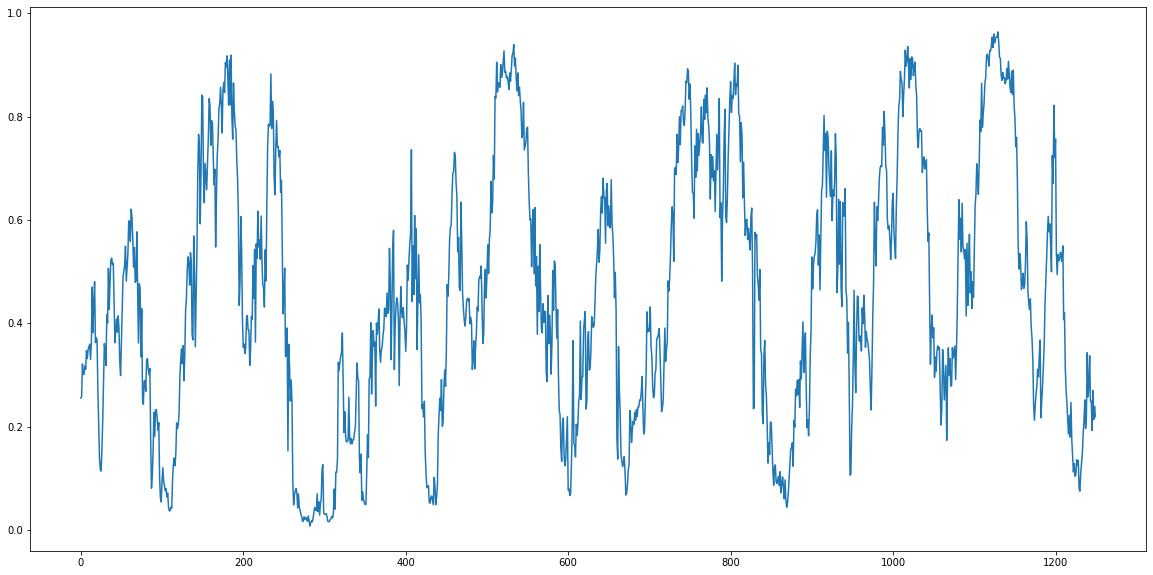

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(y_hat[0:1250])

In [ ]:
# remove ripple locations in movement periods (within 0.5s of movement event)
# smoothen run_speed by 1s boxcar filter:
run_speed = np.convolve(speed, ss.boxcar(Fs) / Fs, 'same')
# keep ripples where run_speed == 0:
ripple_locations = ripple_locations[run_speed[ripple_locations] <= 4]

In [ ]:
# define `probability` as value of y_hat at time of events
# (so not in the strict sense as in statistics)
probability = y_hat[ripple_locations]

## Get samples of LFPs etc. for each detected ripple event

In [ ]:
def get_samples(lfp, lfp_bp, lfp_S, ripple_locations, lag=100, Fs=1250):
    '''
    Parameters:
    -----------
    Returns:
    --------
    '''
    # create arrays
    X = [] # container for raw data segments
    X_bp = [] # container for gamma-band data segments
    X_S = []  # container for specgram
    
    sample_size = lag * 2 + 1

    for ind in ripple_locations:
        offset = -sample_size // 2        
        
        idx = np.arange(sample_size) + ind + offset
        if idx.min() < 0:
            idx -= idx.min()
        elif idx.max() >= lfp.size:
            idx = idx - (idx.max() - lfp.size + 1) 
        X.append(lfp[idx])
        X_bp.append(lfp_bp[idx])
        X_S.append(lfp_S[idx, ])
        
    # convert to numpy arrays, downcast to single precision
    X = np.array(X).astype(np.float32)
    X_bp = np.array(X_bp).astype(np.float32)
    X_S = np.array(X_S).astype(np.float32)
    
    return X, X_bp, X_S

In [ ]:
# fetch or compute bandpass-filtered LFP
# if 'X1' in list(f[session].keys()):
#     lfp_bp = f[session]['X1'][:]
# else:
# lfp_bp = ss.filtfilt(b, a, lfp)

In [ ]:
# Container for spectrograms
lfp_S = np.empty((lfp.size, S_freqs.size), dtype=complex)

#apply wavelets
for i, wavelet in enumerate(wavelets):
    lfp_S[:, i] = ss.convolve(lfp.flatten(), wavelet, 'same')

# compute envelope
lfp_S = np.abs(lfp_S).astype(np.float32)**2

## Get samples around ripple locations

In [ ]:
X, X_bp, X_S = get_samples(lfp, lfp_bp, lfp_S, ripple_locations, lag=lag, Fs=Fs)

In [ ]:
lags = (np.arange(lag * 2 + 1) - lag) * 1000 / Fs

In [ ]:
vmin, vmax = np.exp(np.percentile(np.log(X_S.flatten()), [1, 99]))

In [ ]:
from google.colab import files

with open('ripple_samples.pkl', 'wb') as f:
    pickle.dump(ripple_locations,f)
    pickle.dump(probability,f)
    pickle.dump(X, f)
    pickle.dump(X_bp, f)
    pickle.dump(X_S, f)
    pickle.dump(lags, f)
    pickle.dump(vmin, f)
    pickle.dump(vmax, f)

files.download('ripple_samples.pkl')    

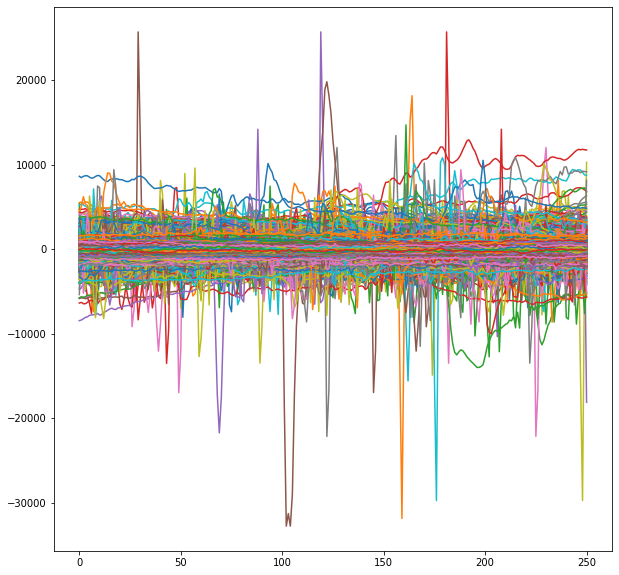

In [ ]:
plt.figure(figsize=(10,10))
plt.plot(X.T)
plt.show()

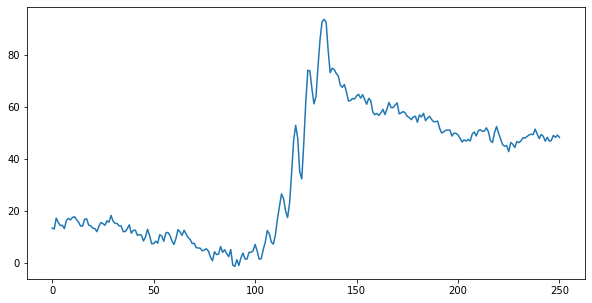

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(np.mean(X,axis=0))
plt.show()

In [ ]:
X.shape

(11514, 251)

## plot samples, reject noise events etc.

Define sorting order (either `chronological`, `probability`, `probability_reversed`, `random`, `None`)

In [ ]:
sort_order = 'random'
if sort_order is None or sort_order == 'chronological':
    sorting = np.arange(X.shape[0])
elif sort_order == 'random':
    sorting = np.random.permutation(np.arange(X.shape[0]))
elif sort_order == 'probability':
    sorting = np.argsort(probability)[::-1]
elif sort_order == 'probability_reversed':
    sorting = np.argsort(probability)

In [ ]:
class RippleNetPlot:
    '''Main object for figure, axes and mouse-click events'''
    def __init__(self, ncols=10, figsize=(9,5)):

        # create figure and axes
        nrows = 3
        
        (self.fig, self.axes) = plt.subplots(nrows, ncols, sharex=True, sharey='row', figsize=figsize)
        self.fig.subplots_adjust(left=0.1, right=0.95, bottom=0.1, top=0.95, wspace=0.05)
        
        # annotate plots
        self.axes[0, 0].set_ylabel('(mV)', labelpad=0)
        self.axes[1, 0].set_ylabel('(mV)', labelpad=0)
        self.axes[2, 0].set_ylabel('$f$ (Hz)', labelpad=0)
        self.axes[2, 0].set_xticks([lags[0], 0, lags[-1]])
        self.axes[2, 0].set_xticklabels([lags[0], 0])
        self.axes[2, 0].set_xlabel(r'$\tau$ (ms)', labelpad=0)
        
        self.axes[0, 0].set_ylim(-0.5, 0.5)
        self.axes[1, 0].set_ylim(-0.1, 0.1)

        self.nrows = nrows
        self.ncols = ncols

        self._event_axes = []

        self.rejected = []

        self.button_presses = 0

        self.cid = self.fig.canvas.mpl_connect('button_press_event', self.on_click)

    '''def disconnect(self):
        self.fig.canvas.mpl_disconnect(self.cid)'''

    def on_click(self, event):
        '''
        Detects mouse click in axes
        '''
        if event.inaxes == axnext:
            #for ax in self._event_axes:
            #    c
            self._event_axes = []
            return # ignore clicks on button

        (_, col) = np.where(self.axes == event.inaxes)

        if not event.inaxes in self._event_axes:
            for ax in self.axes[:, col]:
                self._event_axes.append(ax)

            self.rejected.append(col[0] + self.button_presses * self.ncols)

            event.inaxes.patch.set_facecolor('gray')
        else:
            for ax in self.axes[:, col]:
                self._event_axes.remove(ax)

            self.rejected.remove(col[0] + self.button_presses * self.ncols)

            event.inaxes.patch.set_facecolor('white')

        plt.gcf().canvas.draw()

        return

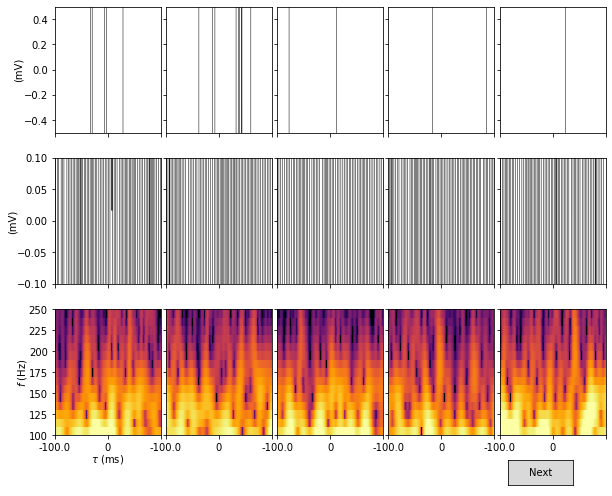

In [ ]:
plt.close('all')

# create interactive plot
plot = RippleNetPlot(ncols=5, figsize=(9,7))
axes = plot.axes

for j in range(plot.ncols):
    try:
        k = sorting[j]
        plot.axes[0, j].plot(lags, X[k] - X[k].mean(), 'k', lw=0.5)
        plot.axes[1, j].plot(lags, X_bp[k], 'k', lw=0.5)
        plot.axes[2, j].pcolormesh(lags, S_freqs, X_S[k].T,
                                   norm=colors.LogNorm(vmin=vmin, vmax=vmax),
                                   cmap='inferno')
        #plot.axes[0, j].set_title(r'$\hat{y}=' + '{:.2f}'.format(np.round(probability[k])) + r'$')
    except IndexError:
        plot.axes[0, j].axis('off')
        plot.axes[1, j].axis('off')
        plot.axes[2, j].axis('off')

class ButtonPresses(object):
    button_presses = 0

    def next(self, event):
        self.button_presses += 1

        plot.button_presses = self.button_presses

        for j in range(plot.ncols):
            try:
                k = sorting[self.button_presses * plot.ncols + j]
                plot.axes[0, j].lines[0].set_ydata(X[k] - X[k].mean())
                plot.axes[1, j].lines[0].set_ydata(X_bp[k])
                plot.axes[0, j].axis(plot.axes[0, j].axis('tight'))
                plot.axes[2, j].collections[0].set_array(X_S[k].T[:-1,:-1].ravel())
            except IndexError:
                plot.axes[0, j].lines.pop()
                plot.axes[1, j].lines.pop()
                plot.axes[2, j].collections.pop()
                plot.axes[0, j].axis('off')
                plot.axes[1, j].axis('off')
                plot.axes[2, j].axis('off')

        
        for ax in plot.axes.flatten():
            ax.patch.set_facecolor('white')
        plt.gcf().canvas.draw()

        return

callback = ButtonPresses()
axnext = plt.axes([0.8, 0.0, 0.1, 0.05])
bnext = Button(axnext, 'Next')
bnext.on_clicked(callback.next)
plt.show()

## Process output
Dump label times and status to `.csv`

In [ ]:
raise Exception # ugly, break execution

Exception: ignored

In [ ]:
# create array of rejected (noise) events
rejected = np.array(plot.rejected, dtype=int) 
rejected = rejected[rejected < ripple_locations.size]

In [ ]:
# crate boolean label array for every ripple location (True - ripple event, False - noise event)
ripple_labels = np.ones(ripple_locations.size, dtype=bool)
ripple_labels[sorting[rejected]] = False

In [ ]:
df = pd.DataFrame(data=dict(rippleLocs=ripple_locations[sorting], ripple=ripple_labels))
df

In [ ]:
df.to_csv('{}_ripples.csv'.format(session), index=False)